## Setup

In [1]:
import optilibrary as ot

X_train, y_train, X_test, y_test = ot.importData(0.2)
n, d = X_train.shape

In [2]:
import numpy as np

## Question 1: 
- Apply randomized block coordinate descent to your problem by considering a full batch of your dataset, 
- and compare it with gradient descent. 
- Is the use of coordinate descent beneficial on your problem?

In [3]:
from scipy.linalg import norm
SoftThresh = lambda x, tau: np.sign(x) * np.maximum(np.abs(x)-tau, 0.0)
loss_rcd = lambda A, x, y, lbda: norm(A.dot(x) - y) ** 2 / (2. * n)+ lbda * norm(x,1)
grad_rcd = lambda A, x, y, lbda: A.T.dot(A.dot(x) - y) / n

# Randomized coordinate descent for the LASSO problem
def rcd_lasso(A,y,lbda,ncoord=1,nits=500, step=0.001): 
    objvals = []
    sparsity = []
    
    # Initial iterate
    n,d = A.shape
    x = np.ones(d)
    
    # Lipschitz constants
    # Lvals = norm(A.T.dot(A), axis=0)
    objvals.append( loss_rcd(A,x, y, lbda)) # Initial objective value
    sparsity.append(np.count_nonzero(x)/d) # Number of nonzero coefficients

    for k in range(nits):
        g = grad_rcd(A, x, y, lbda) # Gradient for the smooth part of the objective
        # g = g / np.linalg.norm(g)

        jk = np.random.choice(d,ncoord,replace=False) # Uniform draw without replacement
        # Compute the new iterate by changing only one component
        for j in jk:
            stepj = step
            valj = x[j]-stepj*g[j]
            threshold = stepj*lbda
            x[j] = SoftThresh(valj, threshold)

        #Update
        objvals.append(loss_rcd(A, x, y, lbda) )
        sparsity.append(np.count_nonzero(x)/d)
        g = grad_rcd(A, x, y, lbda)
          
    return x, np.array(objvals), np.array(sparsity)

In [11]:
#Different block values

lbda = [0.001, 0.01, 0.1, 1]
nits=300
th = np.zeros((2, len(lbda), 8))
obj = np.zeros((2, len(lbda), nits+1))
sp = np.zeros((2, len(lbda), nits+1))
step = 0.015

for i in range(len(lbda)):
    l = lbda[i]
    print(l)
    th[0,i,:], obj[0,i,:], sp[0,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=1, nits=nits, step=0.02)
    th[1,i,:], obj[1,i,:], sp[1,i,:] = rcd_lasso(A=X_train, y=y_train, lbda=l, ncoord=d, nits=nits, step=0.02)

errs = [obj[0], obj[1]]
sparsity = [sp[0], sp[1]]
titles = ['RC (nb=1)', 'GD(nb=d)']

0.001
0.01
0.1
1


In [12]:
# import matplotlib as mpl

# c = np.arange(1, len(lbda) + 0)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
# cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
# cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
# cmap1.set_array([])
# cmap2.set_array([])


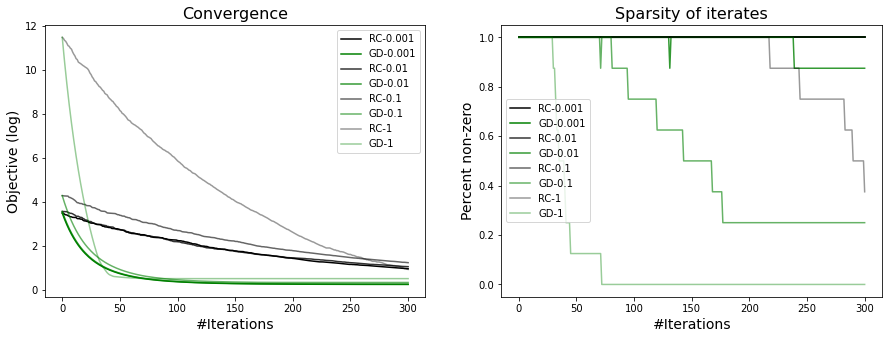

In [13]:
################# Plot the results across all iterations
import matplotlib.pyplot as plt
# Evolution of the loss
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
for i in range(len(lbda)):
    plt.plot(obj[0,i,:], label=f'RC-{lbda[i]}', c='k', alpha=1-0.2*i)
    plt.plot(obj[1,i,:], label=f'GD-{lbda[i]}', c='g', alpha=1-0.2*i)

    # plt.semilogy(i,lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend();

# # Evolution of the number of zero coordinates
plt.subplot(1,2,2)
for i in range(len(lbda)):
    plt.plot(sp[0,i,:], label=f'RC-{lbda[i]}', c='k', alpha=1-0.2*i)
    plt.plot(sp[1,i,:], label=f'GD-{lbda[i]}', c='g', alpha=1-0.2*i)

plt.title("Sparsity of iterates", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Percent non-zero", fontsize=14)
plt.legend();

## Question 2: Stochastic RCD
- Combine randomized block coordinate descent with stochastic gradient (i.e. the method from Part 3). 
- Do you observe a benefit from using coordinates together with stochastic gradient?

In [36]:
np.min(1/norm(np.matmul(X_train.T,X_train),axis=0))

5.173046769795244e-05

In [51]:
def stochRCD(A, y, nbatch=1, lbda=0, ncoords=1, n_iter=1000, with_replace=False):    
    # Lipschitz constant
    Lvals = norm(np.matmul(A.T,A),axis=0)

    n, d = A.shape
    th = np.ones(d)/d
    
    loss_evol = [loss_rcd(A, th, y, lbda)]
    sparsity = [np.count_nonzero(th)/d]

    k=0
    e = 1
    while (k < n_iter and norm(th,2) < 10**100):
        # SG: batch indices
        ik = np.random.choice(n,nbatch,replace=with_replace)# Batch gradient
        sg = np.zeros(d)
        for j in range(nbatch):
            gradi = (A[i].dot(th) - y[i]) * A[i] #+ lbda*x <-- l2 norm case
            sg = sg + gradi
        sg = (1/nbatch)*sg
        sg = sg / norm(sg)

        #RCD: coordinates
        jk = np.random.choice(d,ncoords,replace=with_replace) 
        for j in jk:
            stepj =  1/Lvals[j] * (1/(k+1))
            valj = th[j] - stepj * sg[j]
            threshold = stepj*lbda
            th[j] = SoftThresh(valj, threshold)
        
        obj = loss_rcd(A, th, y, lbda)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k*nbatch - e*n >= 0:
            print("Epoch", e, end='\r')
            e+=1
            loss_evol.append(obj)
            sparsity.append(np.count_nonzero(th)/d)


    loss_evol.append(obj)
    # print('')

    return th, np.array(loss_evol), np.array(sparsity)


In [41]:
th = []
obj = []
sparsity = []

NumBlocks = np.arange(1, 9, 1)
nb_epochs =20
nbset=int(n/10)

for nb in NumBlocks:
    x1,obj1,spars1 = stochRCD(A=X_train, y=y_train, lbda=0, nbatch=nbset, ncoords=nb, n_iter=int(nb_epochs*n/nbset), step=5e-5)
    th.append(x1)
    obj.append(obj1)
    sparsity.append(spars1)
    # print(f'Block size: {nb}')
    # print('Final func:',np.round(obj1[-1], 7))
    # print(f'Sparsity: {spars1[-1]} \n')

In [42]:
obj = np.array(obj).T
obj.shape

(21, 8)

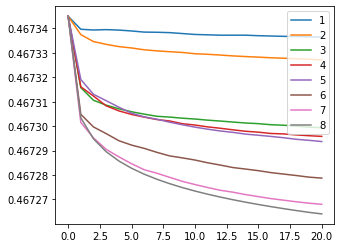

In [43]:
plt.figure(figsize=(5, 4))
plt.plot(obj)
plt.legend(NumBlocks);

### We now compare GD, RCD, SG, BSC
(with no regularisation)

In [62]:
nb_epochs = 30
nbset=int(n/10) #just to speed up runtime

#GD has batch size n and ncoords=d
print("GD")
xGD, objGD, sparsGD = stochRCD(X_train, y_train, nbatch=n, ncoords=d, n_iter=nb_epochs)
# RCD has batch size n and ncoords = 1
print("RCD")
xRCD, objRCD, sparsRCD = stochRCD(X_train, y_train, nbatch=n, ncoords=1, n_iter=nb_epochs)
#SGD has batch size 1 and nblocs=d
print("SG")
xSG, objSG, sparsSG = stochRCD(X_train, y_train, nbatch=nbset, ncoords=d, n_iter=int(nb_epochs*n/nbset))
#BSC
print("BSC")
xBSC, objBSC, sparsBCD = stochRCD(X_train, y_train, nbatch=nbset, ncoords=1, n_iter=int(nb_epochs*n/nbset))



GD
RCDch 30
SGoch 30
BSCch 29


0.4672899766733848
0.4673352055844596
0.46725851518868716
0.4673443257103147


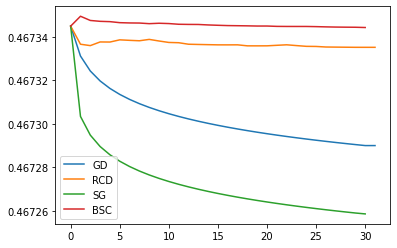

In [63]:
OG = [objGD, objRCD, objSG, objBSC]
# OG = np.array(OG).T #[np.array(i).T for i in OG])
Labels = ['GD', 'RCD', 'SG', 'BSC']
for i in range(len(OG)):
    plt.plot(OG[i])
    print(OG[i][-1])
plt.legend(Labels);


In [ ]:
    """
        Coordinate descent code for LASSO problems of the form
            minimize_x (0.5/n)*||Ax-y||^2 + lbda*||x||_1.
        
        Inputs:
            x0: Initial point
            A: Data matrix
            y: Data vector
            lbda:: Regularization coefficient
            ncoords: Number of coordinates drawn at every iteration
            nits: Maximum number of iterations
            
        Outputs:
            x_output: Last iterate
            objvals: History of function values (Numpy array of length at most nits)
            nnzvals: History of iterate sparsity (Numpy array of length at most nits)
    """